In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Membaca dataset
df = pd.read_csv("Credit_card.csv")
df2 = pd.read_csv("Credit_card_label.csv")

# Menggabungkan dataset berdasarkan 'Ind_ID'
df_merged = pd.merge(df, df2, on='Ind_ID')

In [31]:
# cek missing value
missing_values = df.isnull().sum()
print("Missing Values per Column:\n", missing_values)


Missing Values per Column:
 Ind_ID               0
GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
dtype: int64


In [32]:
# Mengisi nilai NaN pada kolom 'Type_Occupation' dengan 'unknown'
df_merged['Type_Occupation'].fillna('unknown', inplace=True)

# Mengisi nilai NaN pada 'Annual_income' dengan median dari seluruh kolom
median_annual_income = df_merged['Annual_income'].median()
df_merged['Annual_income'].fillna(median_annual_income, inplace=True)

# Mengatasi nilai NaN pada 'Birthday_count' dengan rata-rata kolom tersebut
mean_birthday_count = df_merged['Birthday_count'].mean()
df_merged['Birthday_count'].fillna(mean_birthday_count, inplace=True)

# Menghapus baris dengan nilai NaN pada kolom sisanya
df_merged.dropna(inplace=True)

In [33]:

numerical_cols = ["CHILDREN", "Annual_income", "Birthday_count", "Employed_days",
                  "Mobile_phone", "Work_Phone", "Phone", "EMAIL_ID", "Family_Members"]

categorical_cols = ["GENDER", "Car_Owner", "Propert_Owner", "Type_Income",
                    "EDUCATION", "Marital_status", "Housing_type", "Type_Occupation"]


# Melakukan label encoding pada kolom kategorikal yang memang memerlukan label encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_merged[col] = le.fit_transform(df_merged[col])
    label_encoders[col] = le


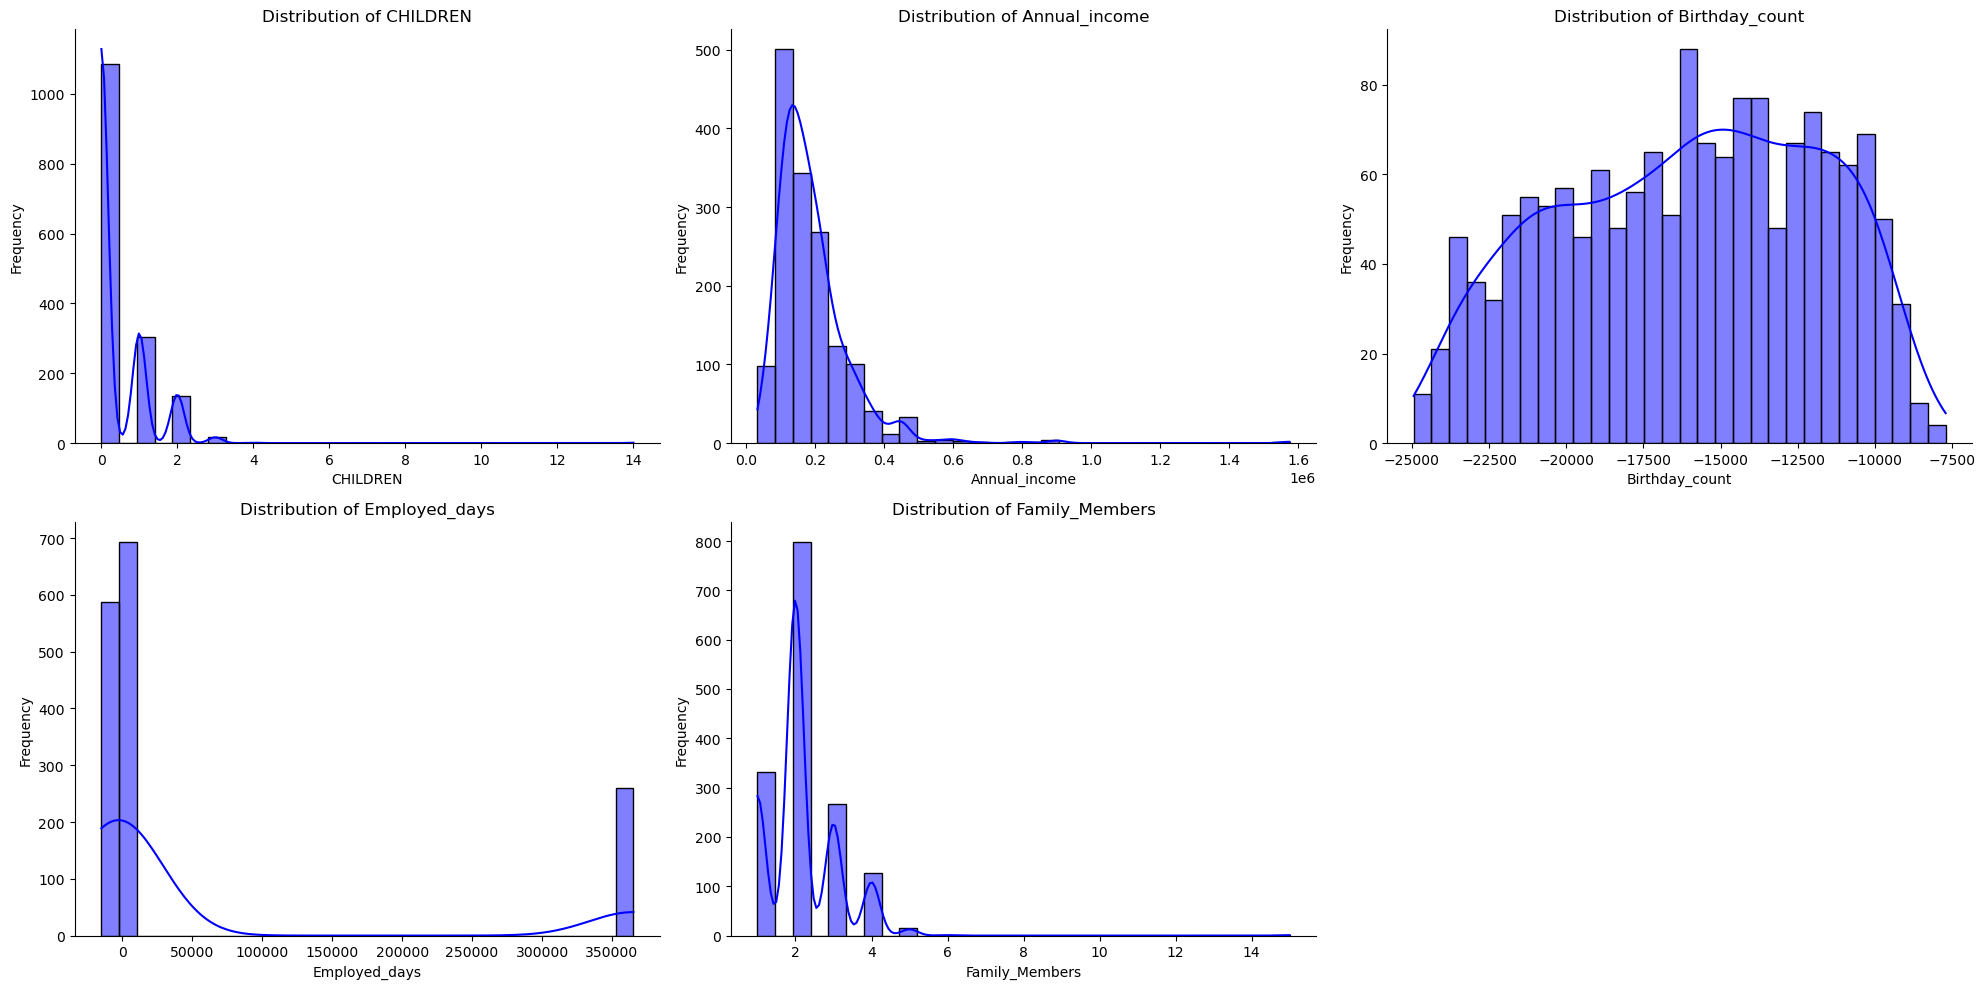

In [34]:
numerical_plot = ["CHILDREN", "Annual_income", "Birthday_count", "Employed_days", "Family_Members"]

# Atur ukuran gambar yang lebih sesuai untuk menampilkan semua plot dengan jelas
plt.figure(figsize=(20, 10))

# Iterasi melalui setiap kolom numerik dan buat subplot
for i, col in enumerate(numerical_plot):
    plt.subplot(2, 3, i + 1)  # Mengatur subplot menjadi 2 baris dan 3 kolom
    sns.histplot(df_merged[col], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    sns.despine()

plt.tight_layout()  # Mengatur layout agar subplot tidak saling tumpang tindih
plt.show()

In [36]:
# Mengubah nilai 'Birthday_count' menjadi nilai absolut
df_merged['Birthday_count'] =df_merged['Birthday_count'].abs()

# Memastikan nilai 'Employed_days' tidak negatif
df_merged['Employed_days'] = df_merged['Employed_days'].abs()

# Capping nilai pada 18,000 hari (sekitar 50 tahun)
df_merged['Employed_days'] = np.where(df_merged['Employed_days'] > 18000, 18000, df_merged['Employed_days'])


# Melakukan transformasi log pada kolom Annual_income untuk mengurangi skewness
df_merged['Annual_income'] = np.log1p(df_merged['Annual_income'])


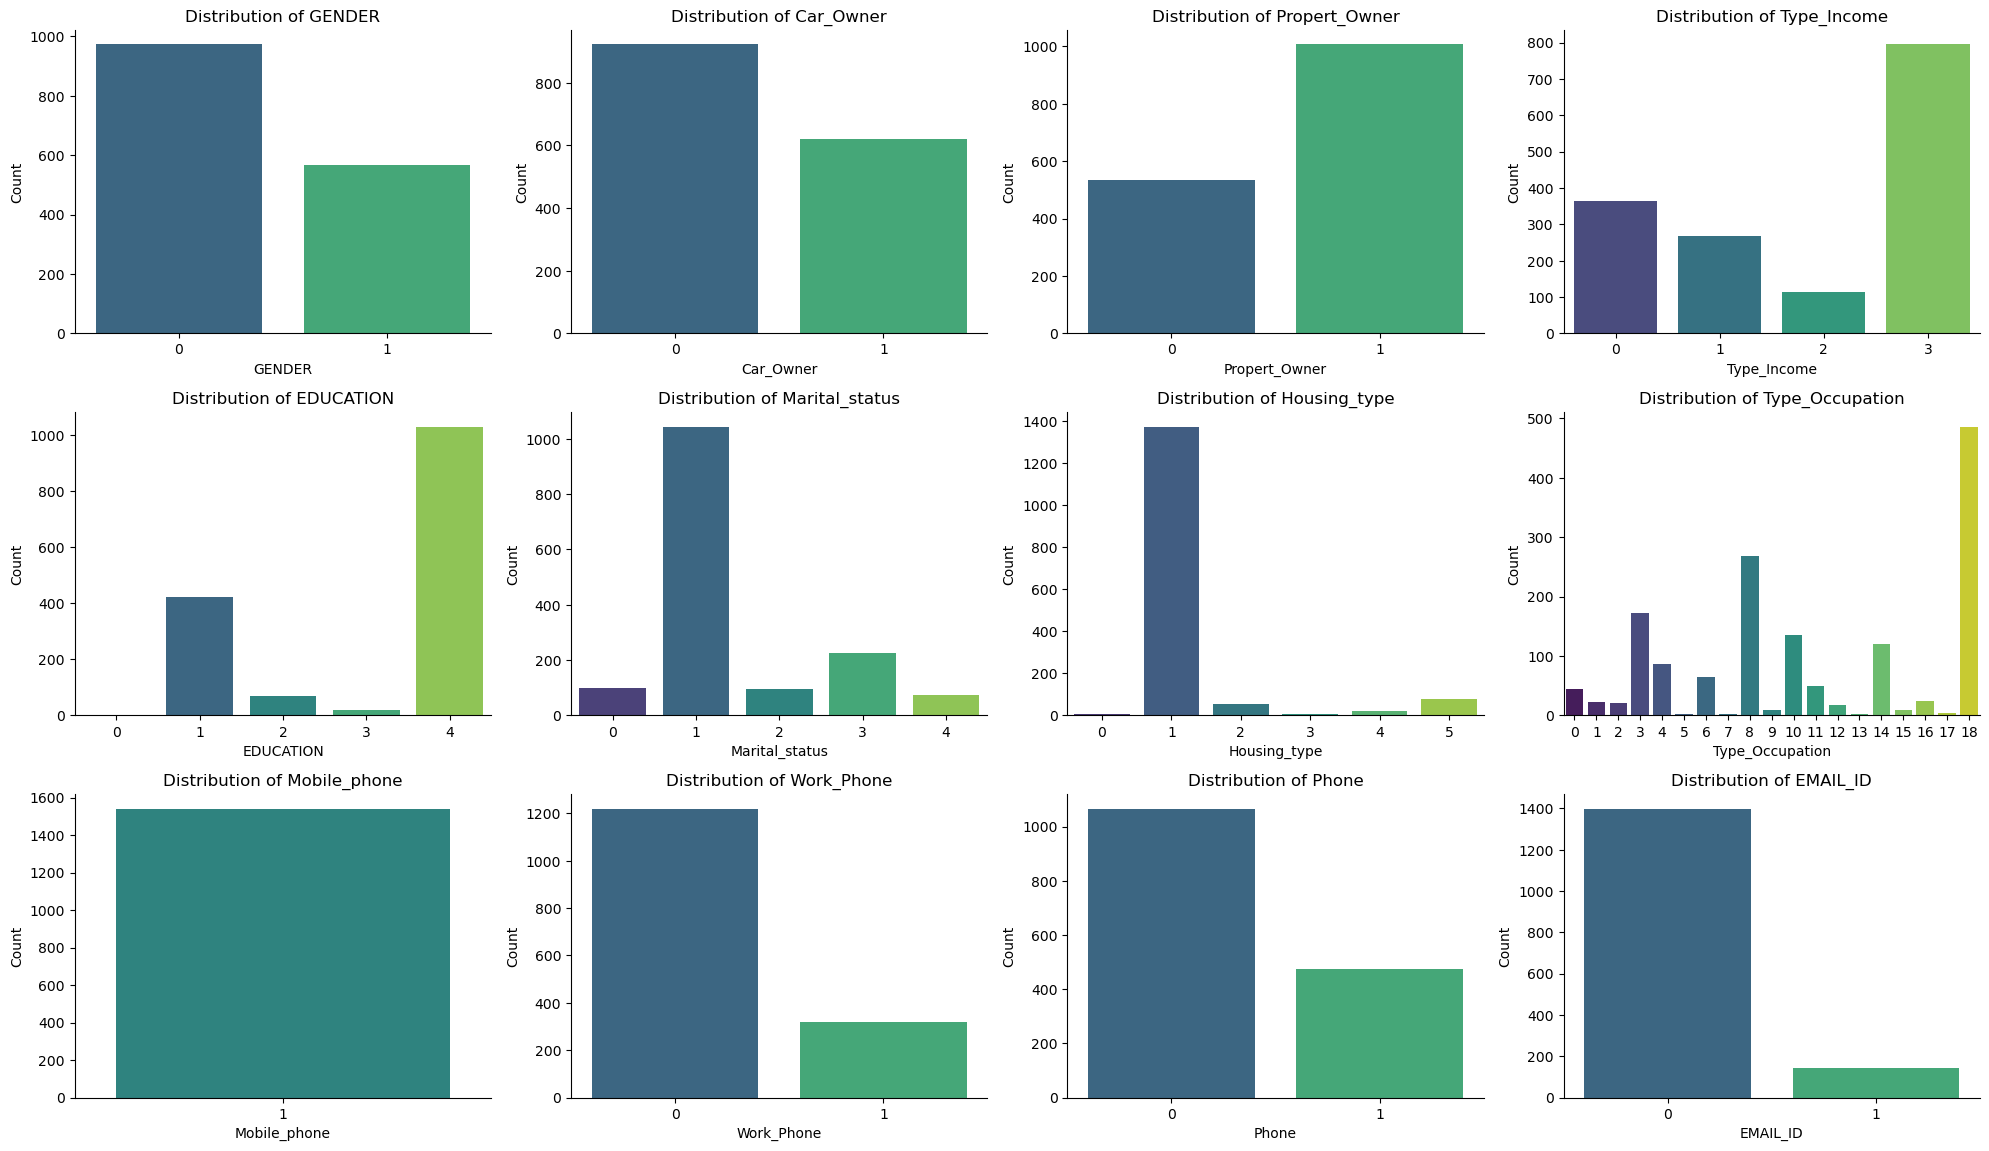

In [37]:
# Daftar kolom yang ingin kita plot sebagai kategorikal
categorical_plot = ["GENDER", "Car_Owner", "Propert_Owner", "Type_Income",
                    "EDUCATION", "Marital_status", "Housing_type", "Type_Occupation",
                    "Mobile_phone", "Work_Phone", "Phone", "EMAIL_ID"]

# Menghitung total jumlah plot yang diperlukan
total_cols = len(categorical_plot)

# Mengatur ukuran figure agar subplot lebih besar dan terlihat jelas
plt.figure(figsize=(20, 15))

# Plot kolom kategorikal sebagai bar plot
for i, col in enumerate(categorical_plot):
    plt.subplot((total_cols // 4) + 1, 4, i + 1)
    sns.countplot(data=df_merged, x=col, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    sns.despine()  

plt.tight_layout()
plt.show()

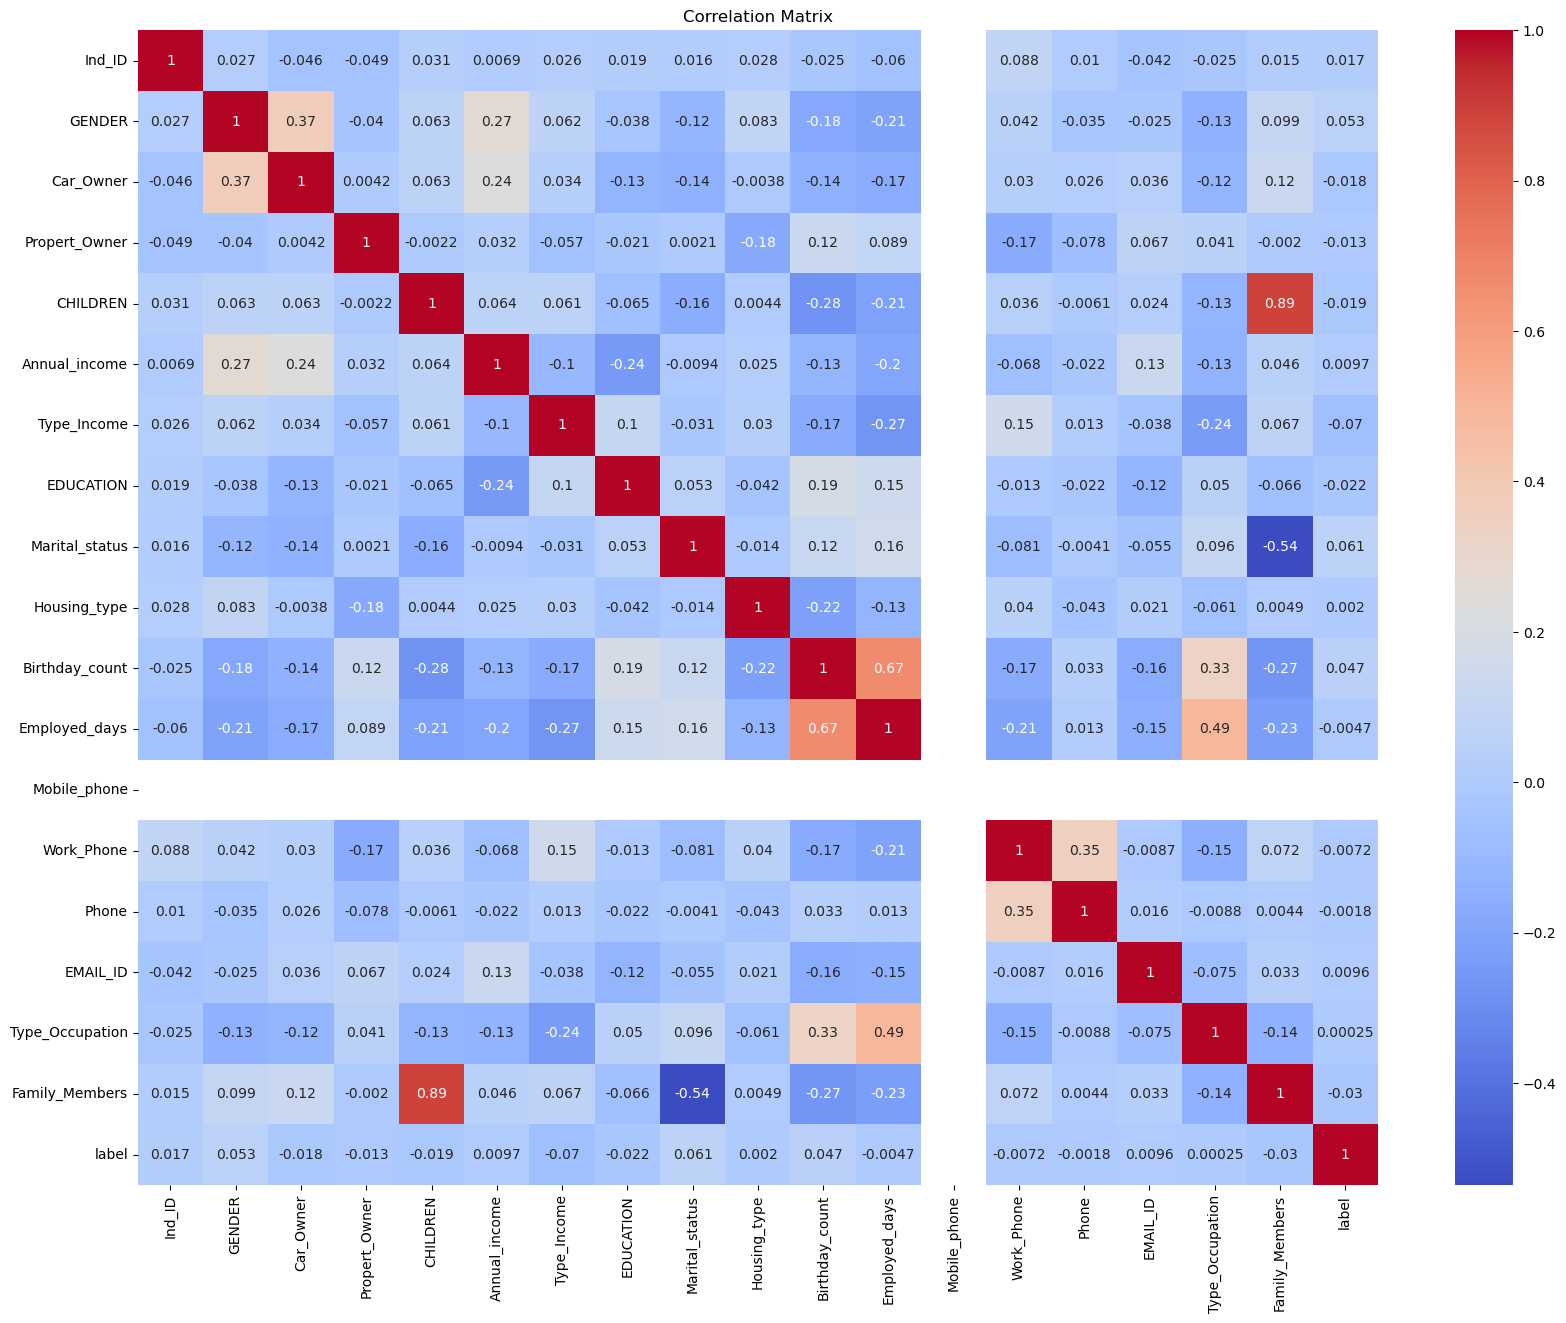

In [38]:
# Menghitung korelasi antara fitur numerik dan target
corr_matrix = df_merged.corr()

# Plot heatmap korelasi dengan ukuran yang lebih besar
plt.figure(figsize=(20, 15))  # Memperbesar ukuran gambar
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [39]:
# atasi korelasi tinggi pada Family member_dan children menggunakan pendekatan rasio
df_merged['Children_to_Family_Ratio'] = df_merged['CHILDREN'] / df_merged['Family_Members']

# Mengisi nilai NaN yang mungkin muncul karena pembagian dengan nol
df_merged['Children_to_Family_Ratio'].fillna(0, inplace=True)


# Menghapus kolom 'CHILDREN' dan 'Family_Members'
df_merged.drop(columns=['CHILDREN', 'Family_Members'], inplace=True)

# Menghapus kolom 'Mobile_phone' karena tidak ada korelasi
df_merged.drop(columns=["Mobile_phone"], inplace=True)

In [40]:
# Memisahkan fitur dan target label
X = df_merged.drop(columns =["label","Ind_ID"])
y = df_merged["label"]

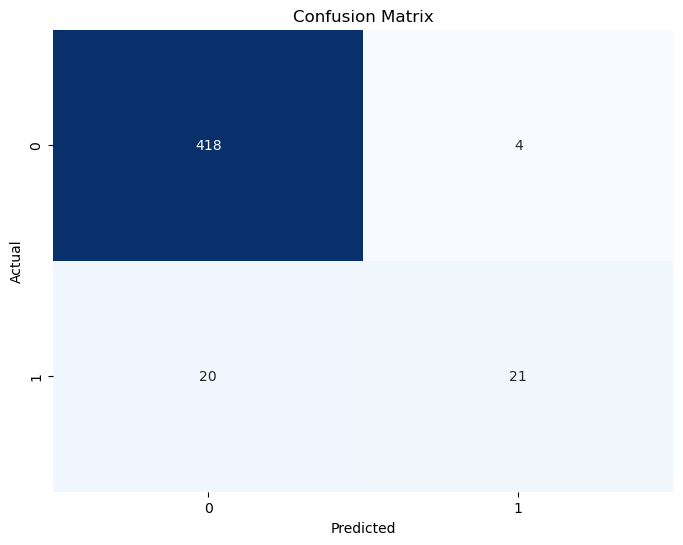

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       422
           1       0.84      0.51      0.64        41

    accuracy                           0.95       463
   macro avg       0.90      0.75      0.80       463
weighted avg       0.94      0.95      0.94       463

ROC-AUC Score: 0.84


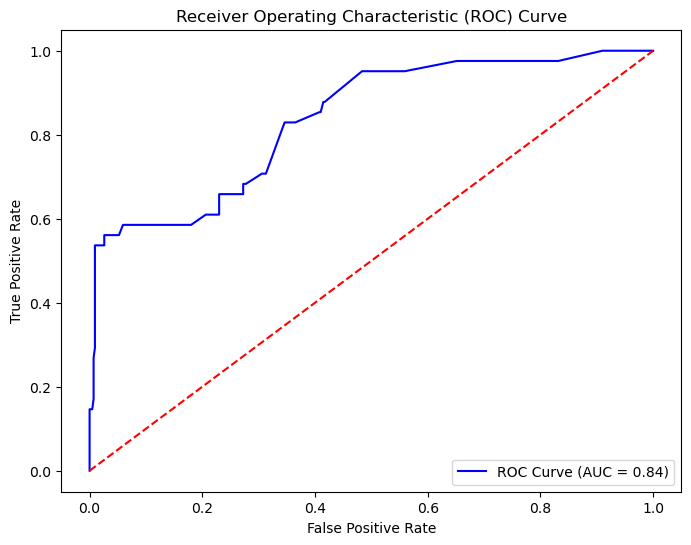

In [41]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Melatih model Random Forest dengan class_weight='balanced'
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')



# Melatih model pada seluruh data training
rf_clf.fit(X_train, y_train)

# Prediksi pada data testing
y_pred = rf_clf.predict(X_test)

# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Membuat heatmap confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluasi hasil model
print(classification_report(y_test, y_pred))

# Prediksi probabilitas pada data testing
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1]

# Menghitung ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Menggambar ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Garis diagonal sebagai baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
# Melakukan cross-validation dengan 10 fold
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring='roc_auc')

# Menampilkan hasil cross-validation
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean AUC Score: {np.mean(cv_scores):.2f}")

Cross-Validation AUC Scores: [0.80647773 0.89595142 0.67773279 0.87206478 0.71700405 0.56072874
 0.87449393 0.65748988 0.87894737 0.6685761 ]
Mean AUC Score: 0.76


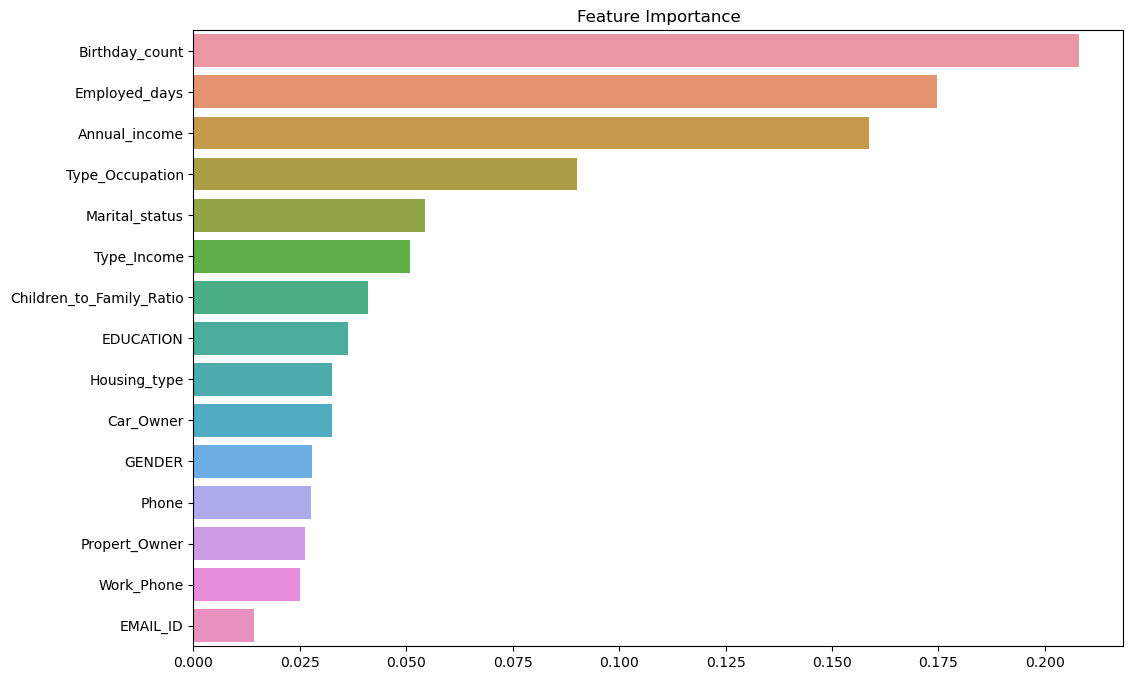

In [43]:
# Mendapatkan feature importance
feature_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Visualisasi feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()